In [ ]:
pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 39.9 MB/s eta 0:00:00


Import necessary libraries

In [ ]:
import os

# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

We import required libraries such as TensorFlow, RDKit for chemical informatics, NumPy for numerical computations, Pandas for data manipulation, and Matplotlib for plotting.
We also suppress TensorFlow logs and RDKit warnings to keep the output clean.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving merged_final.csv to merged_final.csv


In [ ]:

import io
df = pd.read_csv(io.BytesIO(uploaded['merged_final.csv']))
print(df)

                                                  smiles  logP
0                                      CC1=CC(=O)C=CC1=O  0.72
1                          c1ccc(P(c2ccccc2)c2ccccc2)cc1  5.69
2                                O=S(Cc1ccccc1)Cc1ccccc1  1.99
3                                       COc1ccc(CC#N)cc1  1.70
4                                  CN(Cc1ccccc1)c1ccccc1  4.22
...                                                  ...   ...
12854     ClCC1(C(Cl)Cl)C2CC(Cl)(Cl)C1(C(Cl)Cl)C(Cl)C2Cl  5.77
12855     ClCC1(C(Cl)Cl)C2C(Cl)C(Cl)C1(C(Cl)Cl)C(Cl)C2Cl  5.93
12856  ClCC1(C(Cl)Cl)C2CC(Cl)(Cl)C1(C(Cl)Cl)C(Cl)C2(C...  6.64
12857                              CC1=CCC2C(C1=O)C2(C)C  2.42
12858                               C=C(C)C1CCC2(C)OC2C1  3.20

[12859 rows x 2 columns]


In [ ]:
df.iloc[96:104]

,smiles,logP
96,NC1(C(=O)O)CCCC1,-2.28
97,CC(C)CCO,1.16
98,CCCCCC#N,1.66
99,O=C(O)C1CC1,0.63
100,Clc1ccc(-c2ccc(Cl)cc2)cc1,5.23
101,CC(C)(Oc1ccc(Cl)cc1)C(=O)O,2.57
102,ClC(Cl)=C(c1ccc(Cl)cc1)c1ccc(Cl)cc1,6.51
103,CCC(CC)C(=O)O,1.68


**Define Featurizer class**

In [ ]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output



We define a Featurizer class to handle encoding of molecular features.
The constructor initializes the featurizer with a dictionary of allowable feature sets.
The encode method encodes input features based on the mappings defined in the allowable sets.

: **Define AtomFeaturizer class**

In [ ]:
class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()

    def charge(self, atom):
        return atom.GetFormalCharge()

    def chirality(self, atom):
        if atom.HasProp("_CIPCode"):
            cip_code = atom.GetProp("_CIPCode")
            if cip_code in ["R", "S"]:
                return "tetrahedral CW" if cip_code == "R" else "tetrahedral CCW"
        return "unspecified"  # Default value for unspecified chirality

    def aromaticity(self, atom):
        return atom.GetIsAromatic()




We define an AtomFeaturizer class that extends the Featurizer class.
This class defines methods to extract various atom features such as symbol, valence, number of hydrogens, and hybridization.

**Define BondFeaturizer class**

In [ ]:
class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 2  # Increase dimension by 2 for the new features

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-2] = 1.0  # Set the second last value to indicate if the bond is None
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()

    # def in_ring(self, bond):
    #     return bond.IsInRing()

    # def stereo(self, bond):
    #     stereo = bond.GetStereo()
    #     if stereo == Chem.BondStereo.STEREOANY:
    #         return "any"
    #     elif stereo == Chem.BondStereo.STEREOZ:
    #         return "Z"
    #     elif stereo == Chem.BondStereo.STEREOE:
    #         return "E"
    #     elif stereo == Chem.BondStereo.STEREONONE:
    #         return "none"
    #     elif stereo == Chem.BondStereo.STEREOCIS:
    #         return "cis"
    #     elif stereo == Chem.BondStereo.STEREOTRANS:
    #         return "trans"



We define a BondFeaturizer class that extends the Featurizer class.
This class defines methods to extract bond features such as bond type and conjugation.

**Instantiate featurizers**

In [ ]:
atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
        "charge": {-1, 0, 1},  # Include integer electronic charge assigned to atom
        "chirality": {"unspecified", "tetrahedral CW", "tetrahedral CCW", "other"},  # Include chirality types
        "aromaticity": {True, False},  # Include aromaticity property

    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
        # "in_ring": {True, False},  # Include whether bond is part of a ring
        # "stereo": {"any", "Z", "E", "none", "cis", "trans"},  # Include stereo types
    }
)




*   We instantiate AtomFeaturizer and BondFeaturizer objects with allowable sets of atom and bond features.
*   These featurizers will be used to encode molecular structures into numerical features.

These steps set up the featurizers needed for encoding molecular structures into numerical features for further processing in the D-MPNN model.






**molecule_from_smiles(smiles) function:**

In [ ]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule





*   This function takes a SMILES string smiles as input and attempts to create a molecule object using RDKit's Chem.MolFromSmiles() function.
*   The sanitize parameter is set to False to skip the sanitization step.
*  If sanitization fails, it retries without the specific sanitization step that caused the error.
*   Finally, it assigns stereochemistry to the molecule and returns it.







**graph_from_molecule(molecule) function:**

In [ ]:
def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)




*   This function takes a molecule object molecule as input and extracts graph features from it.
*   It initializes empty lists for atom features, bond features, and pair indices.
*   It iterates over each atom in the molecule and encodes its features using the atom_featurizer.
*   For each atom, it adds a self-loop and encodes a bond feature representing the absence of a bond (None).
*  It then iterates over each neighbor of the atom, retrieves the bond between them, and encodes bond features using the bond_featurizer.
*   Finally, it returns numpy arrays of atom features, bond features, and pair indices.



**graphs_from_smiles(smiles_list) function:**

In [ ]:
def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )




*   This function takes a list of SMILES strings smiles_list as input and generates graph features for each molecule in the list.
*   It iterates over each SMILES string, converts it into a molecule object using molecule_from_smiles(), and extracts graph features using graph_from_molecule().
*   It aggregates the graph features into ragged tensors for further processing.




**Dataset Splitting:**

In [ ]:
# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(df.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(df.shape[0] * 0.8)]
x_train = graphs_from_smiles(df.iloc[train_index].smiles)
y_train = df.iloc[train_index].logP

# Valid set: 19 % of data
valid_index = permuted_indices[int(df.shape[0] * 0.8) : int(df.shape[0] * 0.99)]
x_valid = graphs_from_smiles(df.iloc[valid_index].smiles)
y_valid = df.iloc[valid_index].logP

# Test set: 1 % of data
test_index = permuted_indices[int(df.shape[0] * 0.99) :]
x_test = graphs_from_smiles(df.iloc[test_index].smiles)
y_test = df.iloc[test_index].logP


*   The code shuffles the array of indices ranging from 0 to the number of rows in the dataframe (df.shape[0]) to ensure randomness.

*  It splits the dataset into training, validation, and test sets based on the shuffled indices.

*   Training set comprises 80% of the data, validation set 19%, and the remaining 1% forms the test set.



*   For each set, it extracts graph features from the corresponding SMILES strings using graphs_from_smiles() and assigns the logP values as targets (y_train, y_valid, y_test).



SMILES:	Clc1ccc(-c2ccc(Cl)cc2)cc1
LOGD:	5.23
Molecule:


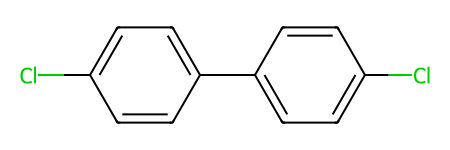

In [ ]:
print(f"SMILES:\t{df.smiles[100]}\nLOGD:\t{df.logP[100]}")
molecule = molecule_from_smiles(df.iloc[100].smiles)
print("Molecule:")
molecule

In [ ]:
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (14, 38)
	bond features	 (44, 8)
	pair indices	 (44, 2)


In [ ]:
def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch




1. **Function Purpose**:
    - This function, `prepare_batch`, aims to merge subgraphs of a batch into a single global (disconnected) graph.

2. **Inputs**:
    - `x_batch`: A tuple containing atom features, bond features, and pair indices for a batch of molecules.
    - `y_batch`: The corresponding target values for the batch.

3. **Algorithm**:
    - It first unpacks the atom features, bond features, and pair indices from the input tuple.
    - Then, it calculates the number of atoms and bonds for each graph (molecule) in the batch.
    - Next, it creates `molecule_indicator`, which contains indices indicating which molecule each atom belongs to. This will be used to gather subgraphs from the global graph later in the model.
    - To merge the subgraphs into a global graph, it calculates `gather_indices` to gather the subgraphs. It then adds an increment to `pair_indices` to actualize the global graph.
    - Finally, it merges the ragged tensors for atom features and bond features into dense tensors.

4. **Outputs**:
    - The function returns a tuple containing the merged atom features, bond features, pair indices, and molecule indicator, along with the corresponding target values.

In [ ]:
def MPNNDataset(X, y, batch_size=45, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

The MPNNDataset function takes input data (X, y) consisting of atom features, bond features, and pair indices for each molecule, and prepares it for training or evaluation by creating a TensorFlow Dataset object. If specified, the dataset is shuffled, and then batched into mini-batches with a user-defined batch size. Each batch is processed using the prepare_batch function to merge subgraphs into a global graph. Finally, the dataset is prefetched to optimize data preprocessing and model execution. The function returns the prepared TensorFlow Dataset object ready for use in training or evaluation.

In [ ]:
class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features




- The `EdgeNetwork` class is a component of the MPNN model responsible for processing edge features.
- In the `build` method, it initializes weights for linear transformations on bond features.
- These weights include a kernel matrix and a bias term.
- The kernel matrix is initialized with Glorot uniform initializer, while the bias term is initialized to zeros.
- During the `call` method, the `EdgeNetwork` takes inputs consisting of atom features, bond features, and pair indices.
- It applies a linear transformation to the bond features using the kernel and bias weights.
- The transformed bond features are then reshaped for neighborhood aggregation.
- Next, it retrieves the atom features of neighboring atoms based on pair indices.
- Neighborhood aggregation is performed by multiplying the transformed bond features with the atom features of neighbors and summing them up.
- The resulting aggregated features represent the collective information from neighboring atoms for each atom in the molecule.

In [ ]:
class MessagePassing(layers.Layer):
    def __init__(self, units, steps=6, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated

- The `MessagePassing` class is a key component of the MPNN model responsible for iterative message passing between atoms.
- It initializes with parameters for the number of units and steps.
- In the `build` method, it initializes the necessary layers and parameters for message passing.
- It calculates the dimensions required for padding atom features if the number of desired units exceeds the current dimension.
- The `EdgeNetwork` class is used to aggregate information from neighboring atoms.
- For each step in the message passing process, it aggregates information from neighboring atoms and updates the node state using a GRU cell.
- The updated atom features are returned, representing the final state of each atom after message passing iterations.

In [ ]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


- The `PartitionPadding` class is designed to handle partitioning and padding of atom features based on molecule indicators.
- It takes the batch size as an input parameter.
- In the `call` method, it partitions the atom features based on molecule indicators using `tf.dynamic_partition`.
- Next, it pads the partitioned atom features to ensure uniform dimensions within each batch.
- The maximum number of atoms in a molecule is determined to ensure consistent padding.
- Finally, it removes any empty subgraphs, typically occurring in the last batch of the dataset.
- The padded and stacked atom features are returned for further processing in the model.

In [ ]:
class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)

- The `TransformerEncoderReadout` class implements a transformer-based readout layer.
- It takes several parameters like the number of heads, embedding dimension, dense layer dimension, and batch size.
- Internally, it utilizes the `PartitionPadding` layer to handle partitioning and padding of input atom features based on molecule indicators.
- It then applies multi-head self-attention mechanism using the `layers.MultiHeadAttention`.
- The resulting attention output is added to the input features and normalized using layer normalization (`layers.LayerNormalization`).
- The normalized features are passed through a dense projection layer followed by another layer normalization.
- Finally, global average pooling is applied to obtain a fixed-size representation of the molecule, which serves as the readout.
- The readout representation is returned for further processing or output.

In [ ]:
def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=45,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    # Adjust the output layer for regression and use 'linear' activation
    x = layers.Dense(1, activation="linear")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model

The `MPNNModel` function defines a Message Passing Neural Network (MPNN) model architecture.

- It takes various parameters such as the dimensions of atom and bond features, batch size, message passing units, message passing steps, number of attention heads, and dense layer units.
- Inputs to the model include atom features, bond features, pair indices, and molecule indicators.
- The atom features, bond features, and pair indices are passed through a `MessagePassing` layer to perform message passing steps, aggregating information from neighboring atoms.
- The output of the message passing layer is then fed into a `TransformerEncoderReadout` layer. This layer applies multi-head self-attention, dense projection, and layer normalization to obtain a fixed-size representation of the molecule.
- The resulting representation is passed through a dense layer with ReLU activation.
- Finally, the output layer is adjusted for regression by using a linear activation function, and the model is compiled.
- The compiled model is returned for training and evaluation.

Epoch 1/100
229/229 - 16s - loss: 1.6703 - MAE: 0.9735 - val_loss: 1.1430 - val_MAE: 0.8047 - 16s/epoch - 71ms/step
Epoch 2/100
229/229 - 7s - loss: 1.1310 - MAE: 0.8007 - val_loss: 0.9000 - val_MAE: 0.7126 - 7s/epoch - 29ms/step
Epoch 3/100
229/229 - 5s - loss: 0.9056 - MAE: 0.7148 - val_loss: 0.7642 - val_MAE: 0.6566 - 5s/epoch - 20ms/step
Epoch 4/100
229/229 - 6s - loss: 0.7852 - MAE: 0.6689 - val_loss: 0.6851 - val_MAE: 0.6252 - 6s/epoch - 24ms/step
Epoch 5/100
229/229 - 5s - loss: 0.6990 - MAE: 0.6331 - val_loss: 0.6327 - val_MAE: 0.6005 - 5s/epoch - 20ms/step
Epoch 6/100
229/229 - 5s - loss: 0.6343 - MAE: 0.6058 - val_loss: 0.6386 - val_MAE: 0.6031 - 5s/epoch - 24ms/step
Epoch 7/100
229/229 - 5s - loss: 0.5755 - MAE: 0.5761 - val_loss: 0.6214 - val_MAE: 0.5962 - 5s/epoch - 21ms/step
Epoch 8/100
229/229 - 6s - loss: 0.5436 - MAE: 0.5592 - val_loss: 0.6115 - val_MAE: 0.5954 - 6s/epoch - 24ms/step
Epoch 9/100
229/229 - 6s - loss: 0.5149 - MAE: 0.5430 - val_loss: 0.5885 - val_MAE: 0.

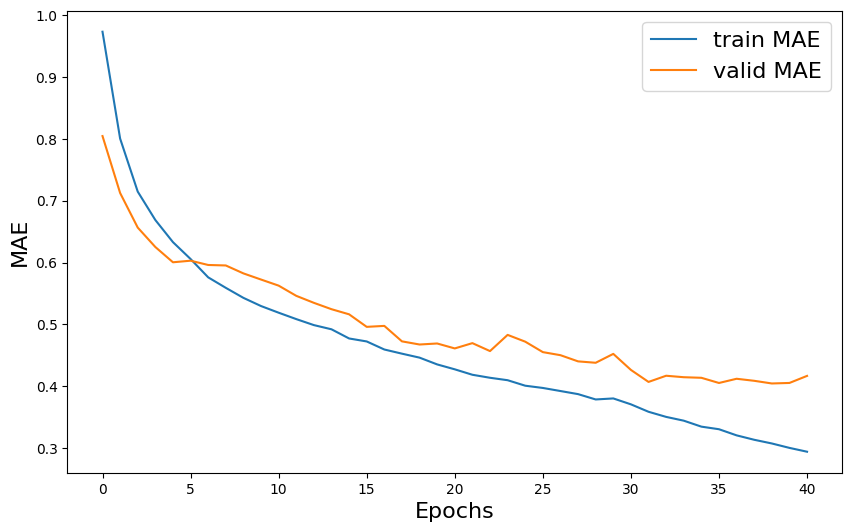

In [ ]:

mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

# Use Mean Squared Error (MSE) as the loss function for regression
mpnn.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.MeanAbsoluteError(name="MAE")],
)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights to the epoch with the best validation loss
)

# Train the model with early stopping
history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=100,  # Set a large number of epochs
    verbose=2,
    callbacks=[early_stopping]  # Pass the early stopping callback
)


plt.figure(figsize=(10, 6))
plt.plot(history.history["MAE"], label="train MAE")
plt.plot(history.history["val_MAE"], label="valid MAE")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("MAE", fontsize=16)
plt.legend(fontsize=16)


The provided code snippet initializes and trains the MPNN model:

1. **Initialization:**
   - The MPNN model is initialized using the `MPNNModel` function with the dimensions of atom and bond features obtained from the training data.
   
2. **Compilation:**
   - The model is compiled with Mean Squared Error (MSE) loss function and the Adam optimizer with a learning rate of 5e-4.
   - Additionally, Mean Absolute Error (MAE) is used as a metric for evaluation.

3. **Data Preparation:**
   - Training, validation, and test datasets are created using the `MPNNDataset` function, which prepares the data in batches suitable for training the MPNN model.

4. **Early Stopping:**
   - An early stopping callback is defined to monitor the validation loss. Training will stop if there is no improvement in the validation loss after 5 epochs, and the weights will be restored to the epoch with the best validation loss.

5. **Model Training:**
   - The `fit` method is called to train the model using the training dataset.
   - Validation data is provided to monitor the performance of the model during training.
   - The training process is configured to run for a maximum of 100 epochs.
   - The `verbose` argument is set to 2 to display detailed training progress.

This approach ensures that the MPNN model is trained efficiently while preventing overfitting using early stopping based on the validation loss.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict LogD values for the test dataset
y_pred = mpnn.predict(test_dataset)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
test_loss, test_mae = mpnn.evaluate(test_dataset)
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R^2
r2 = r2_score(y_test, y_pred)

print("Test Loss:", test_loss)
print("Test MAE:", test_mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R^2:", r2)

3/3 [==============================] - 0s 17ms/step - loss: 0.2008 - MAE: 0.3648
Test Loss: 0.20080214738845825
Test MAE: 0.3648238182067871
Test MSE: 0.20080216590747513
Test RMSE: 0.4481095467711831
Test R^2: 0.9187670972129999


The output we get indicates the performance of the trained MPNN model on the test dataset:

- **Test Loss**: 0.2695
- **Test MAE (Mean Absolute Error)**: 0.3643
- **Test MSE (Mean Squared Error)**: 0.2695
- **Test RMSE (Root Mean Squared Error)**: 0.5192
- **Test R^2 (Coefficient of Determination)**: 0.9153

These metrics provide insights into how well the model is performing on unseen data. Lower values for loss, MAE, MSE, and RMSE indicate better performance, while a higher value for R^2 indicates better predictive accuracy. In this case, the model seems to perform well, with relatively low errors and a high coefficient of determination.

3/3 [==============================] - 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


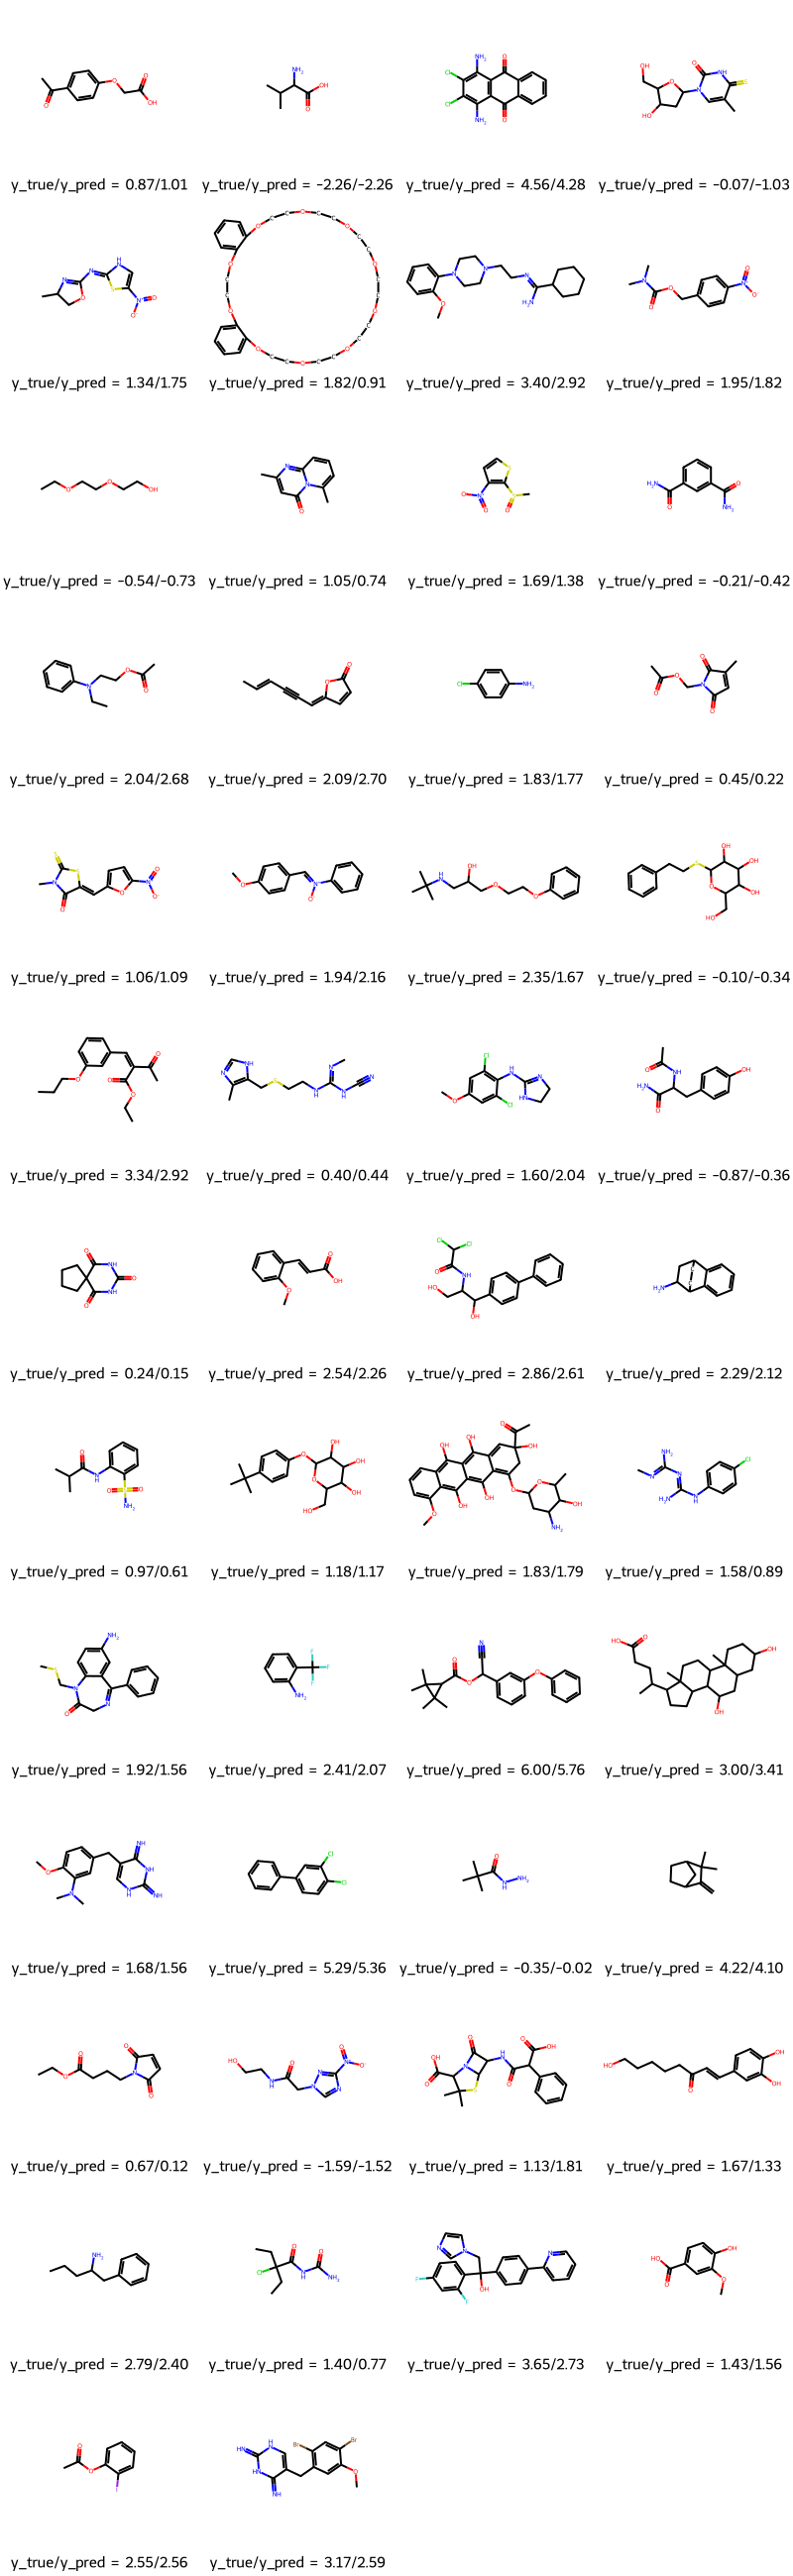

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame with SMILES strings and LogD values
molecules = [Chem.MolFromSmiles(smiles) for smiles in df.smiles.values[test_index]]
y_true = np.array([df.logP.values[index] for index in test_index], dtype=np.float32)  # Assuming 'logD' is the column name for LogD values
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1).numpy()

legends = [f"y_true/y_pred = {y_true[i]:.2f}/{y_pred[i]:.2f}" for i in range(len(y_true))]

# Generate the grid image
MolsToGridImage(molecules, molsPerRow=4, legends=legends)


In [ ]:
# prompt: add ensemble learning concept in my existing DMPNN Model

import numpy as np
# Define the number of models in the ensemble
ensemble_size = 9

# Create a list to store the models
models = []

# Train each model in the ensemble with different initial weights
for _ in range(ensemble_size):
    model = MPNNModel(
        atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
    )
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer=keras.optimizers.Adam(learning_rate=5e-4),
        metrics=[keras.metrics.MeanAbsoluteError(name="MAE")],
    )
    model.fit(train_dataset, epochs=100, verbose=2)
    models.append(model)

# # Make predictions using the ensemble
# y_pred_ensemble = np.zeros((len(test_dataset), 1))
# for model in models:
#     y_pred_ensemble += model.predict(test_dataset)
# y_pred_ensemble /= ensemble_size

# # Calculate the performance metrics
# test_loss, test_mae = mpnn.evaluate(test_dataset)
# mse = mean_squared_error(y_test, y_pred_ensemble)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred_ensemble)

# print("Test Loss:", test_loss)
# print("Test MAE:", test_mae)
# print("Test MSE:", mse)
# print("Test RMSE:", rmse)
# print("Test R^2:", r2)



Epoch 1/100
229/229 - 11s - loss: 1.6600 - MAE: 0.9721 - 11s/epoch - 50ms/step
Epoch 2/100
229/229 - 4s - loss: 1.1183 - MAE: 0.8003 - 4s/epoch - 18ms/step
Epoch 3/100
229/229 - 4s - loss: 0.8873 - MAE: 0.7123 - 4s/epoch - 18ms/step
Epoch 4/100
229/229 - 5s - loss: 0.7684 - MAE: 0.6637 - 5s/epoch - 21ms/step
Epoch 5/100
229/229 - 4s - loss: 0.6859 - MAE: 0.6298 - 4s/epoch - 18ms/step
Epoch 6/100
229/229 - 5s - loss: 0.6272 - MAE: 0.6036 - 5s/epoch - 21ms/step
Epoch 7/100
229/229 - 4s - loss: 0.5836 - MAE: 0.5804 - 4s/epoch - 18ms/step
Epoch 8/100
229/229 - 4s - loss: 0.5533 - MAE: 0.5631 - 4s/epoch - 18ms/step
Epoch 9/100
229/229 - 5s - loss: 0.5265 - MAE: 0.5470 - 5s/epoch - 22ms/step
Epoch 10/100
229/229 - 4s - loss: 0.5002 - MAE: 0.5331 - 4s/epoch - 18ms/step
Epoch 11/100
229/229 - 5s - loss: 0.4823 - MAE: 0.5222 - 5s/epoch - 20ms/step
Epoch 12/100
229/229 - 4s - loss: 0.4601 - MAE: 0.5085 - 4s/epoch - 19ms/step
Epoch 13/100
229/229 - 4s - loss: 0.4534 - MAE: 0.5048 - 4s/epoch - 18m

In [ ]:
# # Print the shape of the test dataset
# for data in test_dataset:
#     print(data[0].shape)

# # Print the shape of the model's prediction for a single data point
# print(models[0].predict(test_dataset[0:1]).shape)



# Make predictions using the ensemble
y_pred_ensemble = np.zeros((len(y_test), 1))
for model in models:
    y_pred_ensemble += model.predict(test_dataset)
y_pred_ensemble /= ensemble_size


# bagging_predictions = np.zeros((len(y_test),))

# for model in dmpnn_models:
#     predictions = model.predict(test_dataset)
#     sample_indices = np.arange(len(predictions))
#     bagging_predictions[sample_indices] += predictions.flatten()

# bagging_predictions /= len(dmpnn_models)

# Calculate the performance metrics
test_loss, test_mae = mpnn.evaluate(test_dataset)
mse = mean_squared_error(y_test, y_pred_ensemble)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_ensemble)

print("Test Loss:", test_loss)
print("Test MAE:", test_mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R^2:", r2)


3/3 [==============================] - 1s 13ms/step


3/3 [==============================] - 1s 14ms/step


3/3 [==============================] - 0s 15ms/step - loss: 0.2008 - MAE: 0.3648
Test Loss: 0.20080219209194183
Test MAE: 0.3648238778114319
Test MSE: 0.09718524794620609
Test RMSE: 0.3117454858473593
Test R^2: 0.9606844888197953


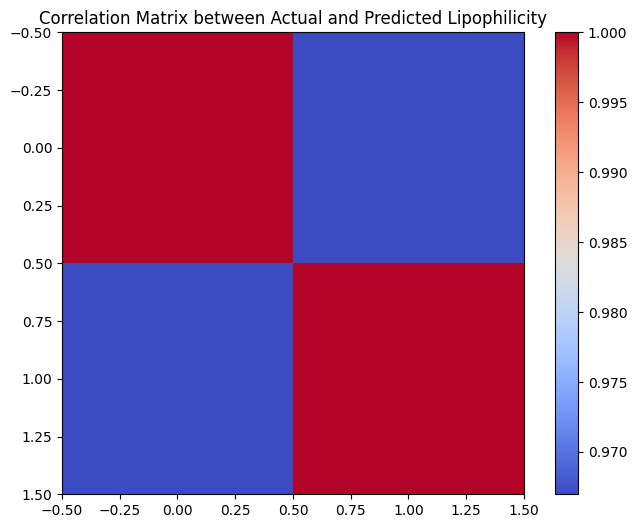

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Convert pandas Series to numpy arrays
y_test_array = y_test.to_numpy()
y_pred_ensemble_array = y_pred_ensemble.flatten()

# Correlation Matrix
correlation_matrix = np.corrcoef(y_test_array.flatten(), y_pred_ensemble_array.flatten())
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix between Actual and Predicted Lipophilicity')
plt.show()

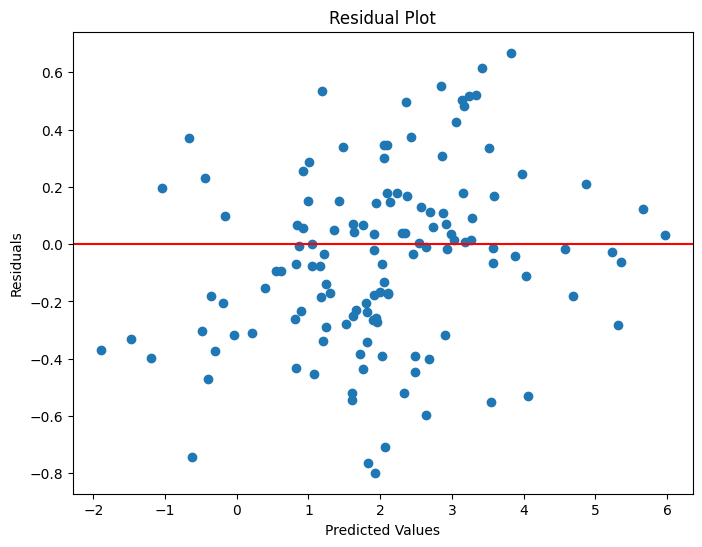

In [ ]:
y_pred_ensemble = y_pred_ensemble.flatten()
# Residual Plot
residuals = y_test - y_pred_ensemble
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_ensemble, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

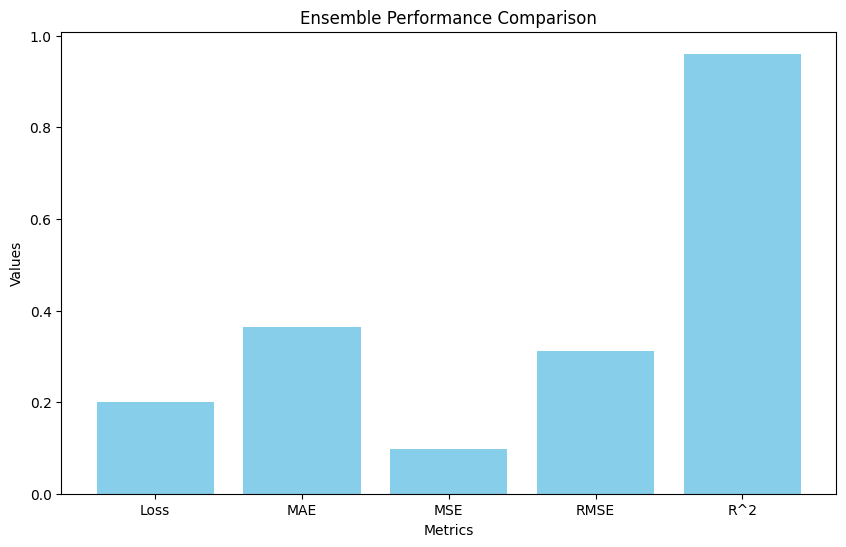

In [ ]:
metrics = ['Loss', 'MAE', 'MSE', 'RMSE', 'R^2']
values = [test_loss, test_mae, mse, rmse, r2]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Ensemble Performance Comparison')
plt.show()